# Extraction of studies via Databases & Registers

In [ ]:
# Standard Packages 
import pandas as pd
import unicodedata
import time
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from datetime import datetime
from typing import Dict, List, Optional, Iterable, Tuple
import unicodedata

# API Call Packages
import urllib
import requests
import json


## Load API Keys

In [230]:
load_dotenv()

# load api keys from .env
api_key_WoS = os.getenv('WEB_OF_SCIENCE_API_KEY')
api_key_SS = os.getenv('SEMANTIC_SCHOLAR_API_KEY')
api_key_Perplexity = os.getenv('PERPLEXITY_API_KEY')

# Check if API keys are loaded
print(f"Web of Science API Key: {api_key_WoS[:3]}...")  
print(f"Semantic Scholar API Key: {api_key_SS[:3]}...")  
print(f"Perplexity API Key: {api_key_Perplexity[:4]}...")

Web of Science API Key: 7c0...
Semantic Scholar API Key: eU3...
Perplexity API Key: pplx...


## Web of Science API Call

**Search and field tags for Web of Science documents**
- `sort_field`: Order by field(s). 
    - Field name and order by clause separated by '+', use A for ASC and D for DESC, 
    - Example: `PY+D`. Multiple values are separated by comma. 
    - Supported fields:  * **LD** - Load Date * **PY** - Publication Year * **RS** - Relevance * **TC** - Times Cited  (optional)
- `...time_span`: Beginning and end dates must be specified in the yyyy-mm-dd format separated by '+' or ' ', e.g. 2023-01-01+2023-12-31. This parameter is not compatible with the all databases search, i.e. db=WOK is not compatible with this parameter. (optional)


In [14]:
# Import WoS API client
import clarivate.wos_starter.client
from clarivate.wos_starter.client.rest import ApiException
from pprint import pprint

In [15]:
# Set up Web of Science API client
BASE_WoS = "https://api.clarivate.com/apis/wos-starter/v1"
configuration = clarivate.wos_starter.client.Configuration(host = BASE_WoS)
configuration.api_key['ClarivateApiKeyAuth'] = api_key_WoS

In [16]:
# Define Functions
# -------------- Function to run API query --------------
def run_wos_api(
        q,                          # Search query in WOS search syntax
        db='WOS',                       # Choice of Database
        limit=50,                       # Set limit of records on page (1-50) (default to 10)
        page=1,                         # Set the result page 
        sort_field='RS+D',              # Order by Field(s), option: LD, PY, RS, TC
        modified_time_span=None,        # Date range in which results were most recently modified.
        tc_modified_time_span=None,     # Date range in which times cited counts were modified.
        detail=None,                    # Set to returns full data by default, alternative: detail=short
        configuration=configuration ):

    with clarivate.wos_starter.client.ApiClient(configuration) as api_client:
        api_instance = clarivate.wos_starter.client.DocumentsApi(api_client)
        try:
            api_response = api_instance.documents_get(
                q,
                db=db,
                limit=limit,
                page=page,
                sort_field=sort_field,
                modified_time_span=modified_time_span,
                tc_modified_time_span=tc_modified_time_span,
                detail=detail
            )
            return api_response
        
        except ApiException as e:
            print(f"Exception when calling DocumentsApi->documents_get: {e}")
            return None
        
# -------------- Function to Fetch --------------
# Funciton: Fetch X number of pages
def wos_fetch_pages(q: str, limit: int = 50) -> pd.DataFrame:
    all_hits = []

    for p in range(1, 11):  # pages 1-10
        resp = run_wos_api(q, page=p, limit=limit)
        if resp is None:
            print(f"[WARN] No response for page {p}")
            continue
        hits = getattr(resp, "hits", []) or []
        all_hits.extend(h.to_dict() for h in hits)

    if not all_hits:
        return pd.DataFrame()

    df = pd.DataFrame(all_hits)
    if "uid" in df.columns:
        df = df.drop_duplicates(subset=["uid"]).reset_index(drop=True)
    return df

# Funciton: Fetch ALL pages
def wos_fetch_all_pages(q: str, limit: int = 50) -> pd.DataFrame:
    # Step 1: Fetch the first page to get the total number of records
    resp = run_wos_api(q, page=1, limit=limit)
    if resp is None:
        print(f"[WARN] No response for the first page of query: {q}")
        return pd.DataFrame()

    total_records = getattr(resp.metadata, "total", 0)  # Get the total number of records
    if total_records == 0:
        print(f"[WARN] No records found for query: {q}")
        return pd.DataFrame()

    # Step 2: Calculate the number of pages required
    total_pages = (total_records + limit - 1) // limit  # equivalent to math.ceil(total_records / limit)

    # Step 3: Loop through all pages and collect the records
    all_hits = []
    for page in range(1, total_pages + 1):
        resp = run_wos_api(q, page=page, limit=limit)
        if resp is None:
            print(f"[WARN] No response for page {page} of query: {q}")
            continue

        hits = getattr(resp, "hits", []) or []
        all_hits.extend(h.to_dict() for h in hits)

    if not all_hits:
        return pd.DataFrame()

    # Step 4: Convert the results to a DataFrame
    df = pd.DataFrame(all_hits)
    
    # Deduplicate based on 'uid' (unique identifier)
    if "uid" in df.columns:
        df = df.drop_duplicates(subset=["uid"]).reset_index(drop=True)

    return df

# Function: Get total record counts for each query
def wos_query_totals(wos_queries: dict) -> pd.DataFrame:
    results = []
    for name, q in wos_queries.items():
        resp = run_wos_api(q, page=1, limit=1)
        print(f"Processing query: {name}")
        
        if resp is None:
            results.append({"QueryName": name, "TotalRecords": None})
            continue

        total = getattr(resp.metadata, "total", None)
        results.append({"QueryName": name, "TotalRecords": total})

    return pd.DataFrame(results).sort_values("TotalRecords", ascending=False).reset_index(drop=True)

In [18]:
# Define search terms

# 1. LLM Block
LLM_Block = 'TS=("large language model*" OR "foundation model*" OR LLM OR LLMs OR GPT OR LLaMA* OR Mistral OR Mixtral OR Claude* OR Gemini OR PaLM OR Qwen OR DeepSeek OR "Falcon 180B" OR "Phi-3")'

# 2. Survey Block
Survey_Block = 'TS=(survey* OR "survey data" OR "survey response*" OR questionnaire* OR question* OR "opinion poll*" OR "public opinion*" OR attitude* OR value* OR norm* OR moral* OR "feeling thermometer*" OR "open-ended" OR "open ended" OR nonresponse OR "non-response" OR respondent* OR participant* OR interview* OR "self-report*" OR "data collection")'

# 3. Simulation Block 
Simulation_BlockA = 'TS=((simulat* OR emulat* OR predict* OR imput* OR "missing data" OR nonresponse OR "non-response" OR "item nonresponse" OR "unit nonresponse" OR "synthetic respondent*" OR "synthetic participant*" OR "artificial respondent*" OR "artificial participant*" OR "virtual respondent*" OR "virtual participant*" OR persona* OR "role play*") NEAR/5 (survey* OR questionnaire* OR respondent* OR response* OR interview* OR "self-report*" OR "data collection" OR opinion* OR poll*))'

Simulation_BlockB = 'TS=( ( simulat* OR emulat* OR predict* OR imput* OR "synthetic data" OR "missing data" OR nonresponse OR "non-response" OR "item nonresponse" OR "synthetic respondent*" OR "synthetic participant*" OR "artificial respondent*" OR "artificial participant*" OR "virtual respondent*" OR "virtual participant*" OR persona* OR "role play*" OR "as a respondent" OR "LLM as respondent" OR "model as respondent" OR proxy OR surrogate OR "stand-in" OR "stand in" OR replac* OR substitut* OR represent* OR fidelit* OR faithful* OR doppelg* OR ("Synthetic Voice*" NEAR/5 (persona* OR respondent* OR survey* OR "public opinion*" OR opinion*)) OR ("representing people" NEAR/3 (survey* OR respondent* OR persona* OR opinion*)) OR ("LLM-generated persona*" OR "LLM generated persona*") ) NEAR/5 (survey* OR questionnaire* OR respondent* OR response* OR interview* OR "self-report*" OR "data collection" OR opinion* OR poll* OR attitude* OR value* OR norm* OR "public opinion*") )'

Simulation_BlockC = 'TS=("survey simulation" OR "simulated participant*" OR "simulated respondent*" OR "synthetic data" OR "synthetic survey data" OR "synthetic respondent*" OR "synthetic participant*" OR "artificial respondent*" OR "artificial participant*" OR "virtual respondent*" OR "virtual participant*" OR "LLM as respondent" OR "model as respondent" OR "as a respondent" OR "role play*" OR persona*)'

# 4. Model Training Block (optional)
Methods_Block = 'TS=( prompt* OR "few-shot" OR "few-shot learning" OR "zero-shot" OR "zero-shot learning" OR "in-context learning" OR ICL OR "chain of thought" OR "self-consistency" OR "system message" OR persona OR personas OR "role prompt*" OR "instruction-tun*" OR "instruction prompt*" OR "fine-tun*" OR ("reinforcement learning with human feedback" OR RLHF) OR ("reinforcement learning with AI feedback" OR RLAIF) OR "temperature parameter" OR "temperature setting" OR "nucleus sampling" OR "top-p sampling" OR "active learning" OR "transfer learning" OR "meta learning" OR "meta-learning" OR "representation learning" OR "continual learning" OR "lifelong learning" )'

# 5. Negation Block (to exclude business applications)
Exclusion_Block = 'TS=("customer service" OR marketing OR "AI in business" OR "business forecasting" OR "predictive models" OR "stock market forecasting" OR "sentiment analysis" OR "AI-powered marketing" OR "business decisions" OR "AI in recruitment" OR "AI adoption intention" OR "predictive patentomics" OR "AI chatbot" OR chatbot* OR "virtual assistant" OR "AI assistant" OR "personal assistant" OR "conversational AI" OR "dialogue systems" OR "digital marketing" OR "marketing strategies" OR "customer experience" OR "AI for customer support" OR "AI in e-commerce" OR "digital transformation" OR "AI in finance" OR "banking AI" OR "AI in retail")'

# Year Filter Block (e.g., 2020-2024)
Year_Block = 'PY=(2022-2025)'

In [24]:
# Create combinations of search blocks 
LLM_and_Survey = f'{LLM_Block} AND {Survey_Block} AND {Year_Block}'
LLM_and_Survey_and_Methods = f'{LLM_Block} AND {Survey_Block} AND {Methods_Block} AND {Year_Block}'
LLM_and_SimulationA = f'{LLM_Block} AND {Simulation_BlockA} AND {Year_Block}'
LLM_and_SimulationB = f'{LLM_Block} AND {Simulation_BlockB} AND {Year_Block}'
LLM_and_SimulationC = f'{LLM_Block} AND {Simulation_BlockC} AND {Year_Block}'
LLM_and_Methods = f'{LLM_Block} AND {Methods_Block} AND {Year_Block}'
LLM_and_Survey_and_SimulationA = f'{LLM_Block} AND {Survey_Block} AND {Simulation_BlockA} AND {Year_Block}'
LLM_and_Survey_and_SimulationB = f'{LLM_Block} AND {Survey_Block} AND {Simulation_BlockB} AND {Year_Block}'
LLM_and_Survey_and_SimulationC = f'{LLM_Block} AND {Survey_Block} AND {Simulation_BlockC} AND {Year_Block}'
LLM_and_SimulationA_and_Methods = f'{LLM_Block} AND {Simulation_BlockA} AND {Methods_Block} AND {Year_Block}'
LLM_and_SimulationB_and_Methods = f'{LLM_Block} AND {Simulation_BlockB} AND {Methods_Block} AND {Year_Block}'
LLM_and_SimulationC_and_Methods = f'{LLM_Block} AND {Simulation_BlockC} AND {Methods_Block} AND {Year_Block}'

In [ ]:
# DEFINE Set of Queries
wos_queries = {
    "LLM_and_SimulationA": LLM_and_SimulationA,
    "LLM_and_SimulationB": LLM_and_SimulationB,
    "LLM_and_SimulationC": LLM_and_SimulationC,
    # "LLM_and_Survey_and_SimulationA": LLM_and_Survey_and_SimulationA,
    # "LLM_and_Survey_and_SimulationB": LLM_and_Survey_and_SimulationB,
    # "LLM_and_Survey_and_SimulationC": LLM_and_Survey_and_SimulationC,
    "LLM_and_SimulationA_and_Methods": LLM_and_SimulationA_and_Methods,
    "LLM_and_SimulationB_and_Methods": LLM_and_SimulationB_and_Methods,
    "LLM_and_SimulationC_and_Methods": LLM_and_SimulationC_and_Methods
}

In [29]:
# RUN: Get Max Total records
df_WoS_totals = wos_query_totals(wos_queries)
df_WoS_totals

Processing query: LLM_and_SimulationA
Processing query: LLM_and_SimulationB
Processing query: LLM_and_SimulationC
Processing query: LLM_and_Survey_and_SimulationA
Processing query: LLM_and_Survey_and_SimulationB
Processing query: LLM_and_Survey_and_SimulationC
Processing query: LLM_and_SimulationA_and_Methods
Processing query: LLM_and_SimulationB_and_Methods
Processing query: LLM_and_SimulationC_and_Methods


,QueryName,TotalRecords
0,LLM_and_SimulationC,3827
1,LLM_and_Survey_and_SimulationC,1503
2,LLM_and_SimulationC_and_Methods,1406
3,LLM_and_SimulationB,1223
4,LLM_and_Survey_and_SimulationB,922
5,LLM_and_SimulationA,561
6,LLM_and_SimulationB_and_Methods,329
7,LLM_and_Survey_and_SimulationA,320
8,LLM_and_SimulationA_and_Methods,169


In [31]:
# RUN Fetch for ALL queries
dfs_WoS = {}
for name, query in wos_queries.items():
    print(f"\nFetching WoS results for: {name}")
    df = wos_fetch_all_pages(query, limit=50)
    print(f"{name}: {len(df)} rows")
    dfs_WoS[name] = df


Fetching WoS results for: LLM_and_SimulationA
LLM_and_SimulationA: 561 rows

Fetching WoS results for: LLM_and_SimulationB
LLM_and_SimulationB: 1223 rows

Fetching WoS results for: LLM_and_SimulationC
LLM_and_SimulationC: 3827 rows

Fetching WoS results for: LLM_and_Survey_and_SimulationA
LLM_and_Survey_and_SimulationA: 320 rows

Fetching WoS results for: LLM_and_Survey_and_SimulationB
LLM_and_Survey_and_SimulationB: 922 rows

Fetching WoS results for: LLM_and_Survey_and_SimulationC
LLM_and_Survey_and_SimulationC: 1503 rows

Fetching WoS results for: LLM_and_SimulationA_and_Methods
LLM_and_SimulationA_and_Methods: 169 rows

Fetching WoS results for: LLM_and_SimulationB_and_Methods
LLM_and_SimulationB_and_Methods: 329 rows

Fetching WoS results for: LLM_and_SimulationC_and_Methods
LLM_and_SimulationC_and_Methods: 1406 rows


In [32]:
# Define Functions to clean and normalize WoS DataFrames
def authors_from_names(names_obj):
    if isinstance(names_obj, dict):
        people = names_obj.get("authors") or []
        out = []
        for a in people:
            if isinstance(a, dict):
                dn = a.get("displayName") or a.get("wosStandard") or a.get("full_name") or ""
                if dn:
                    out.append(dn)
        return "; ".join(out)
    return ""

def keywords_from_obj(keywords_obj):
    if isinstance(keywords_obj, dict):
        ak = keywords_obj.get("authorKeywords")
        if isinstance(ak, list):
            return "; ".join([k for k in ak if isinstance(k, str)])
        if isinstance(ak, str):
            return ak
    return ""

def doi_from_identifiers(ident_obj):
    if isinstance(ident_obj, dict):
        doi = ident_obj.get("doi")
        if doi:
            return doi
        dois = ident_obj.get("dois")
        if isinstance(dois, list) and len(dois) > 0:
            return dois[0]
    return None

def issn_from_identifiers(ident_obj):
    if isinstance(ident_obj, dict):
        val = ident_obj.get("issn")
        issn = val[0] if isinstance(val, list) and val else val
        return issn
    return None

def isbn_from_identifiers(ident_obj):
    if isinstance(ident_obj, dict):
        val = ident_obj.get("isbn")
        isbn = val[0] if isinstance(val, list) and val else val
        return isbn
    return None

def year_from_source(src_obj):
    if isinstance(src_obj, dict):
        return src_obj.get("publishYear") or src_obj.get("publishedYear")
    return None

def first_source_type(st_list):
    if isinstance(st_list, list) and st_list:
        return st_list[0]
    return None

def clean_wos_df(df_raw: pd.DataFrame) -> pd.DataFrame:
    if df_raw is None or df_raw.empty:
        return pd.DataFrame(columns=["title", "authors", "doi", "year", "keywords", "sourceType"])

    df = df_raw.copy()

    # Compute desired fields
    df["authors"] = df["names"].apply(authors_from_names) if "names" in df.columns else ""
    df["doi"] = df["identifiers"].apply(doi_from_identifiers) if "identifiers" in df.columns else None
    df["issn"] = df["identifiers"].apply(issn_from_identifiers) if "identifiers" in df.columns else None
    df["isbn"] = df["identifiers"].apply(isbn_from_identifiers) if "identifiers" in df.columns else None
    df["year"] = df["source"].apply(year_from_source) if "source" in df.columns else None
    df["keywords"] = df["keywords"].apply(keywords_from_obj) if "keywords" in df.columns else ""
    df["sourceType"] = df["sourceTypes"].apply(first_source_type) if "sourceTypes" in df.columns else None

    # Drop intermediate/noisy columns
    to_drop = ["uid", "types", "sourceTypes", "source", "names", "links", "citations", "identifiers"]
    df = df.drop(columns=[c for c in to_drop if c in df.columns], errors="ignore")

    # Reorder columns (keep others after the key fields)
    key_cols = [c for c in ["title", "authors", "doi", "issn", "isbn",
                            "year", "keywords", "sourceType"] if c in df.columns]
    other_cols = [c for c in df.columns if c not in key_cols]
    df = df[key_cols + other_cols]

    return df

In [34]:
# RUN Cleaning for Allsets
dfs_WoS_clean = {name: clean_wos_df(df) for name, df in dfs_WoS.items()}

# df_WoS_LLM_and_Survey_clean = dfs_WoS_clean["LLM_and_Survey"]
# df_WoS_LLM_and_Survey_and_Methods_clean = dfs_WoS_clean["LLM_and_Survey_and_Methods"]
df_WoS_LLM_and_SimulationA_clean = dfs_WoS_clean["LLM_and_SimulationA"]
df_WoS_LLM_and_SimulationB_clean = dfs_WoS_clean["LLM_and_SimulationB"]
df_WoS_LLM_and_SimulationC_clean = dfs_WoS_clean["LLM_and_SimulationC"]
# df_WoS_LLM_and_Methods_clean = dfs_WoS_clean["LLM_and_Methods"]
df_WoS_LLM_and_Survey_and_SimulationA_clean = dfs_WoS_clean["LLM_and_Survey_and_SimulationA"]
df_WoS_LLM_and_Survey_and_SimulationB_clean = dfs_WoS_clean["LLM_and_Survey_and_SimulationB"]
df_WoS_LLM_and_Survey_and_SimulationC_clean = dfs_WoS_clean["LLM_and_Survey_and_SimulationC"]
df_WoS_LLM_and_SimulationA_and_Methods_clean = dfs_WoS_clean["LLM_and_SimulationA_and_Methods"]
df_WoS_LLM_and_SimulationB_and_Methods_clean = dfs_WoS_clean["LLM_and_SimulationB_and_Methods"]
df_WoS_LLM_and_SimulationC_and_Methods_clean = dfs_WoS_clean["LLM_and_SimulationC_and_Methods"]
# df_WoS_LLMSurvey_or_LLMSimulationA_clean = dfs_WoS_clean["LLMSurvey or LLMSimulationA"]
# df_WoS_LLMSurvey_or_LLMSimulationB_clean = dfs_WoS_clean["LLMSurvey or LLMSimulationB"]
# df_WoS_LLMSurvey_or_LLMSimulationC_clean = dfs_WoS_clean["LLMSurvey or LLMSimulationC"]
# df_WoS_Survey_and_SimulationA_clean = dfs_WoS_clean["Survey_and_SimulationA"]
# df_WoS_Survey_and_SimulationB_clean = dfs_WoS_clean["Survey_and_SimulationB"]
# df_WoS_Survey_and_SimulationC_clean = dfs_WoS_clean["Survey_and_SimulationC"]

In [ ]:
# Save cleaned dataframes to CSV files
df_WoS_LLM_and_SimulationA_clean.to_csv("results_wos/df_WoS_LLM_and_SimulationA.csv", index=False)
df_WoS_LLM_and_SimulationB_clean.to_csv("results_wos/df_WoS_LLM_and_SimulationB.csv", index=False)
df_WoS_LLM_and_SimulationC_clean.to_csv("results_wos/df_WoS_LLM_and_SimulationC.csv", index=False)
df_WoS_LLM_and_Survey_and_SimulationA_clean.to_csv("results_wos/df_WoS_LLM_and_Survey_and_SimulationA.csv", index=False)
df_WoS_LLM_and_Survey_and_SimulationB_clean.to_csv("results_wos/df_WoS_LLM_and_Survey_and_SimulationB.csv", index=False)
df_WoS_LLM_and_Survey_and_SimulationC_clean.to_csv("results_wos/df_WoS_LLM_and_Survey_and_SimulationC.csv", index=False)
df_WoS_LLM_and_SimulationA_and_Methods_clean.to_csv("results_wos/df_WoS_LLM_and_SimulationA_and_Methods.csv", index=False)
df_WoS_LLM_and_SimulationB_and_Methods_clean.to_csv("results_wos/df_WoS_LLM_and_SimulationB_and_Methods.csv", index=False)
df_WoS_LLM_and_SimulationC_and_Methods_clean.to_csv("results_wos/df_WoS_LLM_and_SimulationC_and_Methods.csv", index=False)

In [130]:
# load all saved dataframes in "AIRESIL\results_wos"
df_WoS_LLM_and_SimulationA_clean = pd.read_csv("results_wos/df_WoS_LLM_and_SimulationA.csv")
df_WoS_LLM_and_SimulationB_clean = pd.read_csv("results_wos/df_WoS_LLM_and_SimulationB.csv")
df_WoS_LLM_and_SimulationC_clean = pd.read_csv("results_wos/df_WoS_LLM_and_SimulationC.csv")
df_WoS_LLM_and_Survey_and_SimulationA_clean = pd.read_csv("results_wos/df_WoS_LLM_and_Survey_and_SimulationA.csv")
df_WoS_LLM_and_Survey_and_SimulationB_clean= pd.read_csv("results_wos/df_WoS_LLM_and_Survey_and_SimulationB.csv")
df_WoS_LLM_and_Survey_and_SimulationC_clean = pd.read_csv("results_wos/df_WoS_LLM_and_Survey_and_SimulationC.csv")
df_WoS_LLM_and_SimulationA_and_Methods_clean = pd.read_csv("results_wos/df_WoS_LLM_and_SimulationA_and_Methods.csv")
df_WoS_LLM_and_SimulationB_and_Methods_clean = pd.read_csv("results_wos/df_WoS_LLM_and_SimulationB_and_Methods.csv")
df_WoS_LLM_and_SimulationC_and_Methods_clean = pd.read_csv("results_wos/df_WoS_LLM_and_SimulationC_and_Methods.csv")


## Semantic Scholar API Call

In [85]:
from semanticscholar import SemanticScholar

In [86]:
# Define Search Parameters
FIELDS_SS = ["paperId", "title", "year", "authors", "abstract", "url", 
             "citationCount", "externalIds", "publicationTypes"]
YEAR_FILTER = "2022-"
BULK_SORT = "citationCount:desc"
MAX_PAPERS_PER_GROUP = 1000

In [87]:
# Define Search Function

# -------- Helper Functions --------
def author_names(paper_authors):
    if not paper_authors:
        return ""
    names = []
    for a in paper_authors:
        # supports Author objects and dicts
        names.append(getattr(a, "name", a.get("name") if isinstance(a, dict) else None))
    return ", ".join([n for n in names if n])

def _safe_get(container, key):
    """Access dict or object attribute safely."""
    if container is None:
        return None
    if isinstance(container, dict):
        return container.get(key)
    return getattr(container, key, None)

def _fos_to_str(x):
    if not x:
        return None
    vals = []
    if isinstance(x, list):
        for it in x:
            if isinstance(it, str):
                vals.append(it)
            elif isinstance(it, dict):
                vals.append(it.get("name") or it.get("category"))
            else:
                vals.append(getattr(it, "name", None) or getattr(it, "category", None))
    if not vals:
        return None
    vals = [v for v in vals if v]
    return "; ".join(sorted(set(vals))) if vals else None

def _enrich_fos_with_batch(df: pd.DataFrame, sch: SemanticScholar) -> pd.DataFrame:
    ids = [i for i in df.get("paperId", pd.Series()).dropna().astype(str).unique().tolist() if i]
    if not ids:
        df[["fieldsOfStudy", "s2FieldsOfStudy"]] = None
        return df
    chunksize = 100  # /graph/v1/paper/batch limit
    rows = []
    for i in range(0, len(ids), chunksize):
        batch = ids[i:i+chunksize]
        papers = sch.get_papers(batch, fields=["paperId", "fieldsOfStudy", "s2FieldsOfStudy"])
        for p in papers or []:
            pid = getattr(p, "paperId", None)
            fos = getattr(p, "fieldsOfStudy", None)
            s2  = getattr(p, "s2FieldsOfStudy", None)
            rows.append({
                "paperId": pid,
                "fieldsOfStudy": _fos_to_str(fos),
                "s2FieldsOfStudy": _fos_to_str(s2),
            })
    fos_df = pd.DataFrame(rows).drop_duplicates(subset=["paperId"]) if rows else pd.DataFrame(columns=["paperId","fieldsOfStudy","s2FieldsOfStudy"])
    return df.merge(fos_df, on="paperId", how="left")

def ss_paper_row(p):
    ext = getattr(p, "externalIds", None)

    return {
        "paperId": getattr(p, "paperId", None),
        "title": getattr(p, "title", None),
        "year": getattr(p, "year", None),
        "authors": author_names(getattr(p, "authors", None)),
        "abstract": getattr(p, "abstract", None),
        "url": getattr(p, "url", None),
        "citationCount": getattr(p, "citationCount", None),
        "doi": _safe_get(ext, "DOI") or _safe_get(ext, "doi"),
        "publicationTypes": getattr(p, "publicationTypes", None),
    }

# -------- Main Fetch Function --------

# Funciton: Fetch all pages
def ss_fetch_bulk(tag: str,
                  year_filter: str = YEAR_FILTER,
                  max_papers: int = MAX_PAPERS_PER_GROUP,
                  sort: str | None = BULK_SORT,
                  enrich_fos: bool = True) -> pd.DataFrame:
    if tag not in QUERY_GROUPS:
        raise ValueError(f"Unknown group '{tag}'. Valid keys: {', '.join(QUERY_GROUPS.keys())}")

    sch = SemanticScholar(api_key=api_key_SS, timeout=45, retry=True)
    results = sch.search_paper(
        query=QUERY_GROUPS[tag],
        year=year_filter,
        fields=FIELDS_SS,
        bulk=True,
        sort=sort,
    )

    print(f"Estimated total: {getattr(results, 'total', 'n/a')}")
    rows = []
    for i, p in enumerate(results, 1):
        rows.append(ss_paper_row(p))
        if i >= max_papers:
            break

    df = pd.DataFrame(rows)
    if enrich_fos:
        df = _enrich_fos_with_batch(df, sch)

    desired = [
        "paperId", "title", "year", "authors", "abstract", "url", "citationCount", "doi", "publicationTypes", "fieldsOfStudy", "s2FieldsOfStudy",
    ]
    for c in desired:
        if c not in df.columns:
            df[c] = None
    others = [c for c in df.columns if c not in desired]
    return df[desired + others]

# Function: Get total record counts for each query
def ss_query_totals(query_groups: dict,
                    year_filter: str = YEAR_FILTER,) -> pd.DataFrame:
    sch = SemanticScholar
    sch = SemanticScholar(api_key=api_key_SS, timeout=45, retry=True)
    results = []
    for name, query in query_groups.items():
        res = sch.search_paper(
            query=query,
            year=year_filter,
            fields=FIELDS_SS,
            bulk=True,
            sort=BULK_SORT
        )
        total = getattr(res, "total", None)
        results.append({"QueryName": name, "TotalRecords": total})    
    return pd.DataFrame(results).sort_values("TotalRecords", ascending=False).reset_index(drop=True)


In [95]:
# Define Search Query Blocks

# 1. LLM Block
LLM_Block = ('("large language model*" | "foundation model*" | LLM | LLMs | GPT | LLaMA* | Mistral | Mixtral | Claude* | Gemini | PaLM | Qwen | DeepSeek | "Falcon 180B" | "Phi-3")')

# 2. Survey Block
Survey_Block = ('(survey* | "survey data" | "survey response*" | questionnaire* | question* | "opinion poll*" | "public opinion*" | attitude* | value* | norm* | moral* | "feeling thermometer*" | "open-ended" | "open ended" | nonresponse | "non-response" | respondent* | participant* | interview* | "self-report*" | "data collection")')

# 3. Simulation Block
Simulation_BlockA = ('((estimate* | simulat* | emulat* | predict* | imput* |  "item nonresponse" | "synthetic respondent*" | "synthetic participant*" | "artificial respondent*" |  "artificial participant*" | "virtual respondent*" | "virtual participant*" | persona* | "role play*") + (survey* | questionnaire* | respondent* | response* | interview* | "self-report*" |  "data collection" | opinion* | poll*))')

Simulation_BlockB = ('( simulat* | emulat* | predict* | imput* | "synthetic data"|  "item nonresponse" | "synthetic respondent" | "synthetic respondents" | "synthetic participant" |  "synthetic participants" | "artificial respondent" | "artificial participant" | "virtual respondent" | "virtual participant" | persona | personas |  "role play" | "role-playing" | (role + play*) |  "as a respondent" | "LLM as respondent" | "model as respondent" | proxy | surrogate | "stand-in" | "stand in" | replac* | substitut* | represent* | fidelit* | faithful* | doppelg* | ("Synthetic Voice persona"~5 | "persona Synthetic Voice"~5 |   "representing people survey"~5 | "survey representing people"~5 |  "representing people respondent"~5 | "respondent representing people"~5) )')

Simulation_BlockC = ('( "survey simulation" | "simulated participant" | "simulated respondent" |  "synthetic data" | "synthetic survey data" | "synthetic respondent" | "synthetic participant" |  "artificial respondent" | "artificial participant" | "virtual respondent" | "virtual participant" |  "LLM as respondent" | "model as respondent" | "as a respondent" | "role play" | "role-playing" | persona | personas)')

# 4. Model Training Block (optional)
Methods_Block = ('(prompt* | "few-shot" | "few-shot learning" | "zero-shot" | "zero-shot learning" | "in-context learning" | ICL | "chain of thought" | "self-consistency" | "system message" | persona | personas | "role prompt*" | "instruction-tun*" | "instruction prompt*" | "fine-tun*" | ("reinforcement learning with human feedback" | RLHF) | ("reinforcement learning with AI feedback" | RLAIF) | "temperature parameter" | "temperature setting" | "nucleus sampling" | "top-p sampling" | "active learning" | "transfer learning" | "meta learning" | "meta-learning" | "representation learning" | "continual learning" | "lifelong learning")')

#####
Negation_Block1 = ('(customer service | marketing | "AI in business" | "business forecasting" | "predictive models" | "stock market forecasting" | "sentiment analysis" | "AI-powered marketing" | "business decisions" | "AI in recruitment" | "AI adoption intention" | "predictive patentomics" | "AI chatbot" | "chatbots" | "virtual assistant" | "AI assistant" | "personal assistant" | "conversational AI" | "dialogue systems" | "digital marketing" | "marketing strategies" | "customer experience" | "AI for customer support" | "AI in e-commerce" | "digital transformation" | "AI in finance" | "banking AI" | "AI in retail")')

Negation_Block2 = ('(machine learning | artificial intelligence | deep learning | neural network | reinforcement learning | generative models | predictive models | data mining | "classification algorithms" | "computer vision" | "robotics" | "chatbot" | "chat bots" | "conversational AI" | "dialogue systems" | "natural language processing" | "NLP applications" | "chatbot technology" | "chatbot development" | "chatbot applications" | "speech recognition" | "autonomous systems" | "virtual assistant" | "AI assistant" | "personal assistant" | "tasks" | "performance" | "learning" | "research" | "knowledge" | "language models" | "language model" | "based" | "llm" | "models")')

Negation_Block = ('(customer | service | satisfaction | marketing | loyalty | customers | chatbots | businesses | commerce | financial | business | services | banking | experience | digital | chatbot | engagement | study | crm | sales | "Sales" | business* | "AI in business" | "business forecasting" | "sentiment analysis" | "AI-powered marketing" | "business decisions" | "AI in recruitment" | "AI adoption intention" | "predictive patentomics" | "AI chatbot" | "AI assistant" | "personal assistant" | "conversational AI" | "dialogue systems" | "digital marketing" | "marketing strategies" | "customer experience" | "AI for customer support" | "AI in e-commerce" | "digital transformation" | "AI in finance" | service* | banking | "banking AI" | "AI in retail" | "stock market forecasting" | machine learning | artificial intelligence | deep learning | neural network | reinforcement learning | generative models | data mining | "classification algorithms" | "computer vision" | "robotics" | "speech recognition" | "autonomous systems" | "tasks" | "performance" | "learning" | video | visual | multimodal | image | vision | text | images | temporal | engineering)')

# Combinations using + for AND and | for OR
QUERY_GROUPS = {
    # pairs
    #"ss_llm_survey":           f'{LLM_Block} + {Survey_Block}',
    # "ss_llm_simA":             f'{LLM_Block} + {Simulation_BlockA}',
    # "ss_llm_simB":             f'{LLM_Block} + {Simulation_BlockB}',
    # "ss_llm_simC":             f'{LLM_Block} + {Simulation_BlockC}',
    #"ss_llm_methods":          f'{LLM_Block} + {Methods_Block}',
    # "ss_survey_simA":          f'{Survey_Block} + {Simulation_BlockA}',
    # "ss_survey_simB":          f'{Survey_Block} + {Simulation_BlockB}',
    # "ss_survey_simC":          f'{Survey_Block} + {Simulation_BlockC}',

    # triples
    #"ss_llm_survey_methods":       f'{LLM_Block} + {Survey_Block} + {Methods_Block}',
    "ss_llm_survey_simA":          f'{LLM_Block} + {Survey_Block} + {Simulation_BlockA}',
    "ss_llm_survey_simB":          f'{LLM_Block} + {Survey_Block} + {Simulation_BlockB}',
    "ss_llm_survey_simC":          f'{LLM_Block} + {Survey_Block} + {Simulation_BlockC}',
    # "ss_llm_simA_methods":         f'{LLM_Block} + {Simulation_BlockA} + {Methods_Block}',
    # "ss_llm_simB_methods":         f'{LLM_Block} + {Simulation_BlockB} + {Methods_Block}',
    # "ss_llm_simC_methods":         f'{LLM_Block} + {Simulation_BlockC} + {Methods_Block}',

    # with Negation Block
    # "ss_llm_survey_simA_negated": f'{LLM_Block} + {Survey_Block} + {Simulation_BlockA} - {Negation_Block}',
    # "ss_llm_survey_simB_negated": f'{LLM_Block} + {Survey_Block} + {Simulation_BlockB} - {Negation_Block}',
    # "ss_llm_survey_simC_negated": f'{LLM_Block} + {Survey_Block} + {Simulation_BlockC} - {Negation_Block}'
}

In [92]:
# Run: Get Max Total records
df_SS_totals = ss_query_totals(QUERY_GROUPS)
df_SS_totals

,QueryName,TotalRecords
0,ss_llm_survey_simB,14945
1,ss_llm_survey_simA,3824
2,ss_llm_survey_simC,1944


In [93]:
df_SS_llm_survey_simA = ss_fetch_bulk("ss_llm_survey_simA", max_papers = 3824)

Estimated total: 3824


In [52]:
# Run Fetch for all defined queries
# df_SS_llm_survey = ss_fetch_bulk("ss_llm_survey")
df_SS_llm_simA = ss_fetch_bulk("ss_llm_simA", max_papers = 6012)
df_SS_llm_simB = ss_fetch_bulk("ss_llm_simB", max_papers = 10000)
df_SS_llm_simC = ss_fetch_bulk("ss_llm_simC", max_papers = 4574)
# df_SS_survey_simA = ss_fetch_bulk("ss_survey_simA")
# df_SS_survey_simB = ss_fetch_bulk("ss_survey_simB")
# df_SS_survey_simC = ss_fetch_bulk("ss_survey_simC")
# df_SS_llm_survey_simA = ss_fetch_bulk("ss_llm_survey_simA", max_papers = 3550)
# df_SS_llm_survey_simB = ss_fetch_bulk("ss_llm_survey_simB", max_papers = 14893)
# df_SS_llm_survey_simC = ss_fetch_bulk("ss_llm_survey_simC", max_papers = 1939)
df_SS_llm_simA_methods = ss_fetch_bulk("ss_llm_simA_methods", max_papers = 1839)
df_SS_llm_simB_methods = ss_fetch_bulk("ss_llm_simB_methods", max_papers = 10000)
df_SS_llm_simC_methods = ss_fetch_bulk("ss_llm_simC_methods", max_papers = 2505)

# df_SS_llm_survey_simA_negated = ss_fetch_bulk("ss_llm_survey_simA_negated", max_papers = 2500)
# df_SS_llm_survey_simB_negated = ss_fetch_bulk("ss_llm_survey_simB_negated", max_papers = 13947)
# df_SS_llm_survey_simC_negated = ss_fetch_bulk("ss_llm_survey_simC_negated", max_papers = 201)

Estimated total: 6012
Estimated total: 50466
Estimated total: 4574
Estimated total: 1839
Estimated total: 14556
Estimated total: 2505


In [96]:
# Save fetched dataframes to CSV files
df_SS_llm_simA.to_csv("results_ss/df_SS_llm_simA.csv", index=False)
df_SS_llm_simB.to_csv("results_ss/df_SS_llm_simB.csv", index=False)
df_SS_llm_simC.to_csv("results_ss/df_SS_llm_simC.csv", index=False)
df_SS_llm_survey_simA.to_csv("results_ss/df_SS_llm_survey_simA.csv", index=False)
# df_SS_llm_survey_simB.to_csv("results_ss/df_SS_llm_survey_simB.csv", index=False)
# df_SS_llm_survey_simC.to_csv("results_ss/df_SS_llm_survey_simC.csv", index=False)
df_SS_llm_simA_methods.to_csv("results_ss/df_SS_llm_simA_methods.csv", index=False)
df_SS_llm_simB_methods.to_csv("results_ss/df_SS_llm_simB_methods.csv", index=False)
df_SS_llm_simC_methods.to_csv("results_ss/df_SS_llm_simC_methods.csv", index=False)

# df_SS_llm_survey_simA_negated.to_csv("results_ss/df_SS_llm_survey_simA_negated.csv", index=False)
# df_SS_llm_survey_simB_negated.to_csv("results_ss/df_SS_llm_survey_simB_negated.csv", index=False)
# df_SS_llm_survey_simC_negated.to_csv("results_ss/df_SS_llm_survey_simC_negated.csv", index=False)

In [ ]:
# load saved dataframes
df_SS_llm_simA = pd.read_csv("results_ss/df_SS_llm_simA.csv")
df_SS_llm_simB = pd.read_csv("results_ss/df_SS_llm_simB.csv")
df_SS_llm_simC = pd.read_csv("results_ss/df_SS_llm_simC.csv")
df_SS_llm_survey_simA = pd.read_csv("results_ss/df_SS_llm_survey_simA.csv")
df_SS_llm_survey_simB = pd.read_csv("results_ss/df_SS_llm_survey_simB.csv")
df_SS_llm_survey_simC = pd.read_csv("results_ss/df_SS_llm_survey_simC.csv")
df_SS_llm_simA_methods = pd.read_csv("results_ss/df_SS_llm_simA_methods.csv")
df_SS_llm_simB_methods = pd.read_csv("results_ss/df_SS_llm_simB_methods.csv")
df_SS_llm_simC_methods = pd.read_csv("results_ss/df_SS_llm_simC_methods.csv")

### Filter Results



In [58]:
EXCLUDE_FIELDS = (
    'Art|Agricultural and Food Sciences|Biology|Chemistry|Philosophy|Physics|'
    'Materials Science|Education|Engineering|Geography|Geology|History|Law|'
    'Medicine|Mechanics|Orthopedics|Pharmacology'
)
EXCLUDE_PUBTYPES = 'CaseReport|Dataset|Editorial|LettersAndComments|MetaAnalysis|News|Study'

def filter_ss_df(df):
    return df[
        df['s2FieldsOfStudy'].str.contains('Computer Science', na=False) &
        ~df['s2FieldsOfStudy'].str.contains(EXCLUDE_FIELDS, na=False) &
        ~df['publicationTypes'].str.contains(EXCLUDE_PUBTYPES, na=False)
    ]

df_SS_llm_survey_simA_filtered = filter_ss_df(df_SS_llm_survey_simA)
df_SS_llm_survey_simB_filtered = filter_ss_df(df_SS_llm_survey_simB)
df_SS_llm_survey_simC_filtered = filter_ss_df(df_SS_llm_survey_simC)


# nrows of non filtered dataframes
print(f'No. of Rows of df_SS_llm_survey_simA: {len(df_SS_llm_survey_simA)}')
print(f'No. of Rows of df_SS_llm_survey_simB: {len(df_SS_llm_survey_simB)}')
print(f'No. of Rows of df_SS_llm_survey_simC: {len(df_SS_llm_survey_simC)}')

# nrows of filtered dataframes
print(f'No. of Rows of df_SS_llm_survey_simA_filtered: {len(df_SS_llm_survey_simA_filtered)}')
print(f'No. of Rows of df_SS_llm_survey_simB_filtered: {len(df_SS_llm_survey_simB_filtered)}')
print(f'No. of Rows of df_SS_llm_survey_simC_filtered: {len(df_SS_llm_survey_simC_filtered)}')

# save filtered dataframes to CSV files
df_SS_llm_survey_simA_filtered.to_csv("results_ss/df_SS_llm_survey_simA_filtered.csv", index=False)
df_SS_llm_survey_simB_filtered.to_csv("results_ss/df_SS_llm_survey_simB_filtered.csv", index=False)
df_SS_llm_survey_simC_filtered.to_csv("results_ss/df_SS_llm_survey_simC_filtered.csv", index=False)

No. of Rows of df_SS_llm_survey_simA: 3493
No. of Rows of df_SS_llm_survey_simB: 14893
No. of Rows of df_SS_llm_survey_simC: 1939
No. of Rows of df_SS_llm_survey_simA_filtered: 1487
No. of Rows of df_SS_llm_survey_simB_filtered: 6939
No. of Rows of df_SS_llm_survey_simC_filtered: 688


## AI Search: Elicit

In [226]:
# Load Elicit A.I. Search Results (Elicit prompt 1.csv to Elicit prompt 4.csv) each into their respective dataframe
df_Elicit1 = pd.read_csv("data/Elicit prompt 1.csv")
df_Elicit2 = pd.read_csv("data/Elicit prompt 2.csv")
df_Elicit3 = pd.read_csv("data/Elicit prompt 3.csv")
df_Elicit4 = pd.read_csv("data/Elicit prompt 4.csv")

# rename all Title to title
df_Elicit1 = df_Elicit1.rename(columns={"Title": "title"})
df_Elicit2 = df_Elicit2.rename(columns={"Title": "title"})
df_Elicit3 = df_Elicit3.rename(columns={"Title": "title"})
df_Elicit4 = df_Elicit4.rename(columns={"Title": "title"})

df_Elicit = pd.concat([df_Elicit1, df_Elicit2, df_Elicit3, df_Elicit4], ignore_index=True).drop_duplicates(subset=["DOI"]).reset_index(drop=True)


## AI Search: Perplexity

In [231]:
from perplexity import Perplexity

In [ ]:
client = Perplexity(api_key=api_key_Perplexity)

In [ ]:
prompt1 = "How are large language models applied to simulate human survey responses across question types and populations?"

search = client.search.create(
    query=prompt1,
    max_results=10,
    max_tokens_per_page=1024
)

In [238]:
search

SearchCreateResponse(id='3a6de138-2529-4073-bf7c-a5356af60dd9', results=[Result(snippet='## Specializing Large Language Models to Simulate Survey Response Distributions for Global Populations\n\nYong Cao, Haijiang Liu, Arnav Arora, Isabelle Augenstein, Paul Röttger, Daniel Hershcovich... ##### AbstractLarge-scale surveys are essential tools for informing social science research and policy, but running surveys is costly and time-intensive. If we could accurately simulate group-level survey results, this would therefore be very valuable to social science research. Prior work has explored the use of large language models (LLMs) for simulating human behaviors, mostly through prompting. In this paper, we are the first to specialize LLMs for the task of simulating survey response distributions. As a testbed, we use country-level results from two global cultural surveys. We devise a fine-tuning method based on first-token probabilities to minimize divergence between predicted and actual respo

## ArXiv API Call

In [ ]:
import arxiv

In [ ]:
# Define Search
def fetch_results(query, max_results=200, page_size=100):
    client = arxiv.Client(
        page_size=page_size,      # results per page from API
        delay_seconds=3,          # be nice to arXiv
        num_retries=3
    )
    search = arxiv.Search(
        query=query,
        max_results=max_results,
        sort_by=arxiv.SortCriterion.Relevance,
        sort_order=arxiv.SortOrder.Descending,
    )
    seen = set()
    rows = []
    for r in client.results(search):
        if r.entry_id in seen:
            continue
        seen.add(r.entry_id)
        rows.append({
            "arxiv_id": r.get_short_id() if hasattr(r, "get_short_id") else r.entry_id.split('/')[-1],
            "title": r.title.strip(),
            "published": r.published.strftime("%Y-%m-%d") if r.published else "",
            "updated": r.updated.strftime("%Y-%m-%d") if r.updated else "",
            "primary_category": getattr(r, "primary_category", ""),
            "categories": ", ".join(getattr(r, "categories", []) or []),
            "authors": ", ".join(a.name for a in r.authors),
            "summary": r.summary.strip(),
            "pdf_url": r.pdf_url,
            "abs_url": r.entry_id,
        })
    return pd.DataFrame(rows)


In [ ]:
# Define Functions
def author_names(paper_authors):
    if not paper_authors:
        return ""
    names = []
    for a in paper_authors:
        # supports Author objects and dicts
        names.append(getattr(a, "name", a.get("name") if isinstance(a, dict) else None))
    return ", ".join([n for n in names if n])

def paper_row(p):
    return {
        "paperId": getattr(p, "paperId", None),
        "title": getattr(p, "title", None),
        "year": getattr(p, "year", None),
        "authors": author_names(getattr(p, "authors", None)),
        "abstract": getattr(p, "abstract", None),
        "url": getattr(p, "url", None),
        "citationCount": getattr(p, "citationCount", None),
    }

def fetch_bulk_group(sch: SemanticScholar, query: str,
                     year_filter: str, fields: list,
                     max_papers: int, sort: str | None = None):
    """
    Runs a bulk search and yields up to max_papers Paper objects.
    Prints the API estimated total and progress as it goes.
    """
    results = sch.search_paper(
        query=query,
        year=year_filter,     # e.g., "2023-"
        fields=fields,
        bulk=True,            # /graph/v1/paper/search/bulk
        sort=sort,            # only works with bulk=True
    )
    est_total = getattr(results, "total", None)
    print(f"Estimated total: {est_total if est_total is not None else 'n/a'}")

    count = 0
    for p in results:        # iterates across pages automatically
        yield p
        count += 1
        if count >= max_papers:
            break

def fetch_group_df(sch: SemanticScholar, 
                   tag: str, 
                   max_papers_override=None) -> pd.DataFrame:
    """Fetch a single query group and return a DataFrame."""
    if tag not in QUERY_GROUPS:
        valid = ", ".join(QUERY_GROUPS.keys())
        raise ValueError(f"Unknown group '{tag}'. Valid keys: {valid}")

    query = QUERY_GROUPS[tag]
    rows = []
    for paper in fetch_bulk_group(
        sch,
        query=query,
        year_filter=YEAR_FILTER,
        fields=FIELDS,
        max_papers=max_papers_override if max_papers_override is not None else MAX_PAPERS_PER_GROUP,
        sort=BULK_SORT,
    ):
        rows.append(paper_row(paper))

    df = pd.DataFrame(rows, columns=FIELDS)
    return df


# ---------- Main ----------
def main(tag: str | None = None, 
         max_papers_override=None):

    sch = SemanticScholar(api_key=api_key_SS, timeout=45, retry=True)

    if tag is not None:
        return fetch_group_df(sch, tag, max_papers_override=max_papers_override)

    out = {}
    for k in QUERY_GROUPS:
        out[k] = fetch_group_df(sch, k, max_papers_override=max_papers_override)
    return out

# Measure Precision & Recall

## Load Refence Dataset

In [184]:
# Define normalization function (normalize_title)
def normalize_title(s: str) -> str:
    # Unicode normalize
    s = unicodedata.normalize("NFKC", str(s))
    # Lowercase
    s = s.lower()
    # Remove punctuation-like characters
    s = re.sub(r"[^\w\s]", " ", s)   # keep letters, numbers, underscore, whitespace
    # Collapse whitespace
    s = re.sub(r"\s+", " ", s).strip()
    return s

In [185]:
# Load the CSV of Zotero list of papers
gold_df = pd.read_csv("data/LLM - Survey Proxies.csv")

gold_df = gold_df[["Title", "Item Type", "Abstract Note", 
                   "Publication Year", "Author", 
                   "DOI", "ISBN", "ISSN"]].drop_duplicates().reset_index(drop=True)
gold_df["preprint_flag"] = gold_df["Item Type"].apply(lambda x: "preprint" if x == "preprint" else "non-preprint")
gold_df = gold_df.rename(columns={"DOI": "doi", "ISBN": "isbn", "ISSN": "issn"})
gold_df["norm_title"] = gold_df["Title"].apply(normalize_title)

print(f"Gold list size: {len(gold_df)}")

Gold list size: 25


In [175]:
# Remove known papers that doesn't exist in WoS Dataset
bad_titles = [
    "Algorithmic Fidelity of Large Language Models in Generating Synthetic German Public Opinions: A Case Study",
    "Extracting Affect Aggregates from Longitudinal Social Media Data with Temporal Adapters for Large Language Models",
    "The Potential and Challenges of Evaluating Attitudes, Opinions, and Values in Large Language Models"
]

bad_titles_normalized = [normalize_title(t) for t in bad_titles]

gold_df = gold_df[~gold_df["norm_title"].isin(bad_titles_normalized)].reset_index(drop=True) # filter out bad titles

print(f"Cleaned Gold list size: {len(gold_df)} after removing bad entries")

Cleaned Gold list size: 22 after removing bad entries


In [186]:
# Separate sets for preprint and non-preprint for 'calc_recall_with_missing' function
gold_preprint_set = set(gold_df[gold_df["preprint_flag"] == "preprint"]["norm_title"])
gold_non_preprint_set = set(gold_df[gold_df["preprint_flag"] == "non-preprint"]["norm_title"])
gold_norm_set = set(gold_df["norm_title"])

# print the number of unique titles in each set
print(f"Unique titles in gold set: {len(gold_norm_set)}")
print(f"Unique titles in preprint set: {len(gold_preprint_set)}")
print(f"Unique titles in journals & proceedings set: {len(gold_non_preprint_set)}")

Unique titles in gold set: 25
Unique titles in preprint set: 11
Unique titles in journals & proceedings set: 14


## Define Recall Functions

In [187]:
# Define Recall Function
# ---------- Normalizers ----------
def _first_token(s: str) -> str:
    """Return the first nonempty token split on common delimiters."""
    if not isinstance(s, str): 
        return ""
    for tok in re.split(r"[;,|\s]+", s.strip()):
        if tok:
            return tok
    return ""

def normalize_doi(x: str) -> str:
    if not isinstance(x, str): 
        return ""
    x = _first_token(x).lower()
    x = re.sub(r'^(https?://(dx\.)?doi\.org/)', '', x)
    x = x.replace('\u200b', '')  # zero-width
    return x

def normalize_issn(x: str) -> str:
    if not isinstance(x, str): 
        return ""
    s = _first_token(x)
    s = re.sub(r'[^0-9xX]', '', s).upper()
    if len(s) == 8:
        return s[:4] + "-" + s[4:]
    return s

def normalize_isbn(x: str) -> str:
    if not isinstance(x, str): 
        return ""
    s = _first_token(x)
    s = re.sub(r'[^0-9xX]', '', s).upper()
    return s

def canonical_title(s: str) -> str:
    if not isinstance(s, str): 
        return ""
    # strip diacritics
    s = unicodedata.normalize("NFKD", s)
    s = "".join(c for c in s if not unicodedata.combining(c))
    # normalize quotes and dashes/hyphens
    s = s.replace("’", "'").replace("‘", "'").replace("“", '"').replace("”", '"')
    s = s.replace("–", "-").replace("—", "-")
    s = s.lower()
    # fix known glued tokens (extend as needed)
    s = s.replace("financialwellbeing", "financial wellbeing")
    # remove punctuation except spaces and alphanumerics
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    # collapse whitespace
    s = re.sub(r"\s+", " ", s).strip()
    return s

def _ensure_series(df, col):
    vals = df[col] if (isinstance(col, str) and col in df.columns) else pd.Series([""] * len(df), index=df.index)
    return vals.fillna("").astype(str)


# ---------- Main ----------
def calc_recall_with_missing(res_df,
                             gold_df = gold_df,
                             gold_cols=dict(doi="doi", issn="issn", isbn="isbn", title="Title"),
                             res_cols=dict(doi="doi", issn="issn", isbn="isbn", title="title")):
    g = gold_df.copy()
    r = res_df.copy()

    # Normalized keys (robust to missing columns)
    g["_doi"]  = _ensure_series(g, gold_cols.get("doi")).map(normalize_doi)
    r["_doi"]  = _ensure_series(r, res_cols.get("doi")).map(normalize_doi)

    g["_issn"] = _ensure_series(g, gold_cols.get("issn")).map(normalize_issn)
    r["_issn"] = _ensure_series(r, res_cols.get("issn")).map(normalize_issn)

    g["_isbn"] = _ensure_series(g, gold_cols.get("isbn")).map(normalize_isbn)
    r["_isbn"] = _ensure_series(r, res_cols.get("isbn")).map(normalize_isbn)

    g["_tkey"] = _ensure_series(g, gold_cols.get("title")).map(canonical_title)
    r["_tkey"] = _ensure_series(r, res_cols.get("title")).map(canonical_title)

    out = g[[gold_cols["title"]]].rename(columns={gold_cols["title"]: "gold_title"}).copy()
    out[["_doi", "_issn", "_isbn", "_tkey"]] = g[["_doi", "_issn", "_isbn", "_tkey"]]
    out["preprint_flag"] = g["preprint_flag"] if "preprint_flag" in g.columns else pd.NA
    out["matched_by"] = pd.NA
    out["matched_title"] = pd.NA

    def do_join(key: str, label: str):
        nonlocal out, r
        pending = out[out["matched_by"].isna()]
        pending = pending[pending[key].astype(bool)]
        if pending.empty or key not in r.columns:
            return
        pending = pending.assign(_row_id=pending.index)
        if res_cols.get("title") not in r.columns:
            return
        right = r[[res_cols["title"], key]].drop_duplicates().set_index(key)
        merged = pending.join(right, on=key, how="left")
        hits = merged[merged[res_cols["title"]].notna()]
        if hits.empty:
            return
        out.loc[hits["_row_id"], "matched_by"] = label
        out.loc[hits["_row_id"], "matched_title"] = hits[res_cols["title"]].values

    # Priority order
    do_join("_doi",  "doi")
    do_join("_issn", "issn")
    do_join("_isbn", "isbn")
    do_join("_tkey", "title_exact")

    matched_mask = out["matched_title"].notna()
    tp = matched_mask.sum()
    fn = (~matched_mask).sum()
    recall = tp / (tp + fn) if (tp + fn) else 0.0

    pre_mask = out["preprint_flag"].astype(str).str.lower().eq("preprint")
    non_pre_mask = out["preprint_flag"].astype(str).str.lower().eq("non-preprint")

    recall_preprint = (matched_mask & pre_mask).sum() / pre_mask.sum() if pre_mask.sum() else 0.0
    recall_non_preprint = (matched_mask & non_pre_mask).sum() / non_pre_mask.sum() if non_pre_mask.sum() else 0.0

    missing_non_pre_titles = out.loc[(~matched_mask) & non_pre_mask, "gold_title"].tolist()
    missing_pre_titles = out.loc[(~matched_mask) & pre_mask, "gold_title"].tolist()

    return pd.DataFrame([{
        "Number of Papers Retrieved": len(res_df),
        "Recall (All)": f"{recall:.2%}",
        "Recall (Journal & Conf. Papers)": f"{recall_non_preprint:.2%}",
        "Recall (Preprints)": f"{recall_preprint:.2%}",
        "Missing Journal & Conf. Papers": "; ".join(sorted(missing_non_pre_titles)),
        "Missing Preprints": "; ".join(sorted(missing_pre_titles)),
    }])

## Recall Rate - WoS

In [138]:
# Run recall calculations for Subset WoS set
wos_recall_results = {
    "LLM and SimulationA": calc_recall_with_missing(df_WoS_LLM_and_SimulationA_clean),
    "LLM and SimulationB": calc_recall_with_missing(df_WoS_LLM_and_SimulationB_clean),
    "LLM and SimulationC": calc_recall_with_missing(df_WoS_LLM_and_SimulationC_clean),
    "LLM and Survey and SimulationA": calc_recall_with_missing(df_WoS_LLM_and_Survey_and_SimulationA_clean),
    "LLM and Survey and SimulationB": calc_recall_with_missing(df_WoS_LLM_and_Survey_and_SimulationB_clean),
    "LLM and Survey and SimulationC": calc_recall_with_missing(df_WoS_LLM_and_Survey_and_SimulationC_clean),
    "LLM and SimulationA and Methods": calc_recall_with_missing(df_WoS_LLM_and_SimulationA_and_Methods_clean),
    "LLM and SimulationB and Methods": calc_recall_with_missing(df_WoS_LLM_and_SimulationB_and_Methods_clean),
    "LLM and SimulationC and Methods": calc_recall_with_missing(df_WoS_LLM_and_SimulationC_and_Methods_clean),
}

recall_table_WoS = pd.concat(wos_recall_results.values(), 
                                   keys=wos_recall_results.keys()).reset_index(level=1, drop=True).reset_index().rename(columns={"index": "Query"})

print(f"Number of records in Preprint Papers gold set: {len(gold_preprint_set)}")
print(f"Number of records in Journals & Conference Articles gold set: {len(gold_non_preprint_set)}")
recall_table_WoS

Number of records in Preprint Papers gold set: 11
Number of records in Journals & Conference Articles gold set: 11


,Query,Number of Papers Retrieved,Recall (All),Recall (Journal & Conf. Papers),Recall (Preprints),Missing Journal & Conf. Papers,Missing Preprints
0,LLM and SimulationA,561,45.45%,90.91%,0.00%,Knowledge of cultural moral norms in large lan...,AI-Augmented Surveys: Leveraging Large Languag...
1,LLM and SimulationB,1223,50.00%,100.00%,0.00%,,AI-Augmented Surveys: Leveraging Large Languag...
2,LLM and SimulationC,3827,31.82%,63.64%,0.00%,Knowledge of cultural moral norms in large lan...,AI-Augmented Surveys: Leveraging Large Languag...
3,LLM and Survey and SimulationA,320,45.45%,90.91%,0.00%,Knowledge of cultural moral norms in large lan...,AI-Augmented Surveys: Leveraging Large Languag...
4,LLM and Survey and SimulationB,922,50.00%,100.00%,0.00%,,AI-Augmented Surveys: Leveraging Large Languag...
5,LLM and Survey and SimulationC,1503,31.82%,63.64%,0.00%,Knowledge of cultural moral norms in large lan...,AI-Augmented Surveys: Leveraging Large Languag...
6,LLM and SimulationA and Methods,169,27.27%,54.55%,0.00%,Can large language models estimate public opin...,AI-Augmented Surveys: Leveraging Large Languag...
7,LLM and SimulationB and Methods,329,40.91%,81.82%,0.00%,Can large language models estimate public opin...,AI-Augmented Surveys: Leveraging Large Languag...
8,LLM and SimulationC and Methods,1406,27.27%,54.55%,0.00%,Can large language models estimate public opin...,AI-Augmented Surveys: Leveraging Large Languag...


In [ ]:
# Define function: compare_missing_journal_articles
def compare_missing_journal_articles(df_recall, query1, query2):
    row1 = df_recall[df_recall["Query"] == query1]
    row2 = df_recall[df_recall["Query"] == query2]

    # print error for missing queries
    if row1.empty:
        print(f"Error: Query '{query1}' not found in the recall table.")
        return None
    if row2.empty:
        print(f"Error: Query '{query2}' not found in the recall table.")
        return None
    
    missing1 = set(row1.iloc[0]["Missing Journal & Conf. Papers"].split("; ")) if pd.notna(row1.iloc[0]["Missing Journal & Conf. Papers"]) else set()
    missing2 = set(row2.iloc[0]["Missing Journal & Conf. Papers"].split("; ")) if pd.notna(row2.iloc[0]["Missing Journal & Conf. Papers"]) else set()
    
    only_in_1 = missing1 - missing2
    only_in_2 = missing2 - missing1
    in_both = missing1.intersection(missing2)
    
    # output them in a bullet points like
    print(f"Comparison of Missing Journal Articles between '{query1}' and '{query2}':\n")
    print(f"ONly Missing in '{query1}' ({len(only_in_1)} articles):")
    for title in sorted(only_in_1):
        print(f" - {title}")    
    print(f"\nOnly Missing in '{query2}' ({len(only_in_2)} articles):")
    for title in sorted(only_in_2):
        print(f" - {title}")
    print(f"\nMissing In both ({len(in_both)} articles):")
    for title in sorted(in_both):
        print(f" - {title}")

compare_missing_journal_articles(recall_table_WoS_subset,
                                 "LLM and Survey and SimulationA", "LLM and SimulationA")

## Recall Rate - S.S.

In [143]:
# Run recall calculations
ss_recall_results = {
    #"LLM and Survey": calc_recall_with_missing(df_SS_llm_survey),
    "LLM and SimulationA": calc_recall_with_missing(df_SS_llm_simA),
    "LLM and SimulationB": calc_recall_with_missing(df_SS_llm_simB),
    "LLM and SimulationC": calc_recall_with_missing(df_SS_llm_simC),
    #"Survey and SimulationA": calc_recall_with_missing(df_SS_survey_simA),
    #"Survey and SimulationB": calc_recall_with_missing(df_SS_survey_simB),
    #"Survey and SimulationC": calc_recall_with_missing(df_SS_survey_simC),
    "LLM and Survey and SimulationA": calc_recall_with_missing(df_SS_llm_survey_simA),
    "LLM and Survey and SimulationB": calc_recall_with_missing(df_SS_llm_survey_simB),
    "LLM and Survey and SimulationC": calc_recall_with_missing(df_SS_llm_survey_simC),
    "LLM and SimulationA and Methods": calc_recall_with_missing(df_SS_llm_simA_methods),
    "LLM and SimulationB and Methods": calc_recall_with_missing(df_SS_llm_simB_methods),
    "LLM and SimulationC and Methods": calc_recall_with_missing(df_SS_llm_simC_methods),
    # "LLM and Survey and SimulationA Negated": calc_recall_with_missing(df_SS_llm_survey_simA_negated),
    # "LLM and Survey and SimulationB Negated": calc_recall_with_missing(df_SS_llm_survey_simB_negated),
    # "LLM and Survey and SimulationC Negated": calc_recall_with_missing(df_SS_llm_survey_simC_negated),
    # "LLM and Survey and SimulationA Filtered": calc_recall_with_missing(df_SS_llm_survey_simA_filtered),
    # "LLM and Survey and SimulationB Filtered": calc_recall_with_missing(df_SS_llm_survey_simB_filtered),
    # "LLM and Survey and SimulationC Filtered": calc_recall_with_missing(df_SS_llm_survey_simC_filtered),
}

recall_table_SS = pd.concat(ss_recall_results.values(), 
                             keys=ss_recall_results.keys()).reset_index(level=1, drop=True).reset_index().rename(columns={"index": "Query"})
recall_table_SS


,Query,Number of Papers Retrieved,Recall (All),Recall (Journal & Conf. Papers),Recall (Preprints),Missing Journal & Conf. Papers,Missing Preprints
0,LLM and SimulationA,6012,76.00%,85.71%,63.64%,Extracting Affect Aggregates from Longitudinal...,Addressing Systematic Non-response Bias with S...
1,LLM and SimulationB,10000,36.00%,42.86%,27.27%,Algorithmic Fidelity of Large Language Models ...,Addressing Systematic Non-response Bias with S...
2,LLM and SimulationC,4574,44.00%,57.14%,27.27%,Extracting Affect Aggregates from Longitudinal...,AI-Augmented Surveys: Leveraging Large Languag...
3,LLM and Survey and SimulationA,3824,80.00%,92.86%,63.64%,The Potential and Challenges of Evaluating Att...,Addressing Systematic Non-response Bias with S...
4,LLM and Survey and SimulationB,14893,84.00%,92.86%,72.73%,The Potential and Challenges of Evaluating Att...,Addressing Systematic Non-response Bias with S...
5,LLM and Survey and SimulationC,1939,44.00%,57.14%,27.27%,Extracting Affect Aggregates from Longitudinal...,AI-Augmented Surveys: Leveraging Large Languag...
6,LLM and SimulationA and Methods,1839,44.00%,50.00%,36.36%,Can large language models estimate public opin...,Addressing Systematic Non-response Bias with S...
7,LLM and SimulationB and Methods,10000,48.00%,57.14%,36.36%,Can large language models estimate public opin...,Addressing Systematic Non-response Bias with S...
8,LLM and SimulationC and Methods,2505,32.00%,42.86%,18.18%,Can large language models estimate public opin...,AI-Augmented Surveys: Leveraging Large Languag...


In [145]:
# combine recall_table_SS and recall_table_WoS into a dataframe with an additional column 'Source'
recall_table = pd.concat([
    recall_table_SS.assign(Source="Semantic Scholar"),
    recall_table_WoS.assign(Source="Web of Science")
], ignore_index=True)

recall_table.to_csv("recall_table_final.csv", index=False)
recall_table

,Query,Number of Papers Retrieved,Recall (All),Recall (Journal & Conf. Papers),Recall (Preprints),Missing Journal & Conf. Papers,Missing Preprints,Source
0,LLM and SimulationA,6012,76.00%,85.71%,63.64%,Extracting Affect Aggregates from Longitudinal...,Addressing Systematic Non-response Bias with S...,Semantic Scholar
1,LLM and SimulationB,10000,36.00%,42.86%,27.27%,Algorithmic Fidelity of Large Language Models ...,Addressing Systematic Non-response Bias with S...,Semantic Scholar
2,LLM and SimulationC,4574,44.00%,57.14%,27.27%,Extracting Affect Aggregates from Longitudinal...,AI-Augmented Surveys: Leveraging Large Languag...,Semantic Scholar
3,LLM and Survey and SimulationA,3824,80.00%,92.86%,63.64%,The Potential and Challenges of Evaluating Att...,Addressing Systematic Non-response Bias with S...,Semantic Scholar
4,LLM and Survey and SimulationB,14893,84.00%,92.86%,72.73%,The Potential and Challenges of Evaluating Att...,Addressing Systematic Non-response Bias with S...,Semantic Scholar
5,LLM and Survey and SimulationC,1939,44.00%,57.14%,27.27%,Extracting Affect Aggregates from Longitudinal...,AI-Augmented Surveys: Leveraging Large Languag...,Semantic Scholar
6,LLM and SimulationA and Methods,1839,44.00%,50.00%,36.36%,Can large language models estimate public opin...,Addressing Systematic Non-response Bias with S...,Semantic Scholar
7,LLM and SimulationB and Methods,10000,48.00%,57.14%,36.36%,Can large language models estimate public opin...,Addressing Systematic Non-response Bias with S...,Semantic Scholar
8,LLM and SimulationC and Methods,2505,32.00%,42.86%,18.18%,Can large language models estimate public opin...,AI-Augmented Surveys: Leveraging Large Languag...,Semantic Scholar
9,LLM and SimulationA,561,45.45%,90.91%,0.00%,Knowledge of cultural moral norms in large lan...,AI-Augmented Surveys: Leveraging Large Languag...,Web of Science


## Recall Rate - Elicit A.I.

In [227]:
elicit_recall_results = {
    "Elicit Prompt 1": calc_recall_with_missing(df_Elicit1),
    "Elicit Prompt 2": calc_recall_with_missing(df_Elicit2),
    "Elicit Prompt 3": calc_recall_with_missing(df_Elicit3),
    "Elicit Prompt 4": calc_recall_with_missing(df_Elicit4),
    "Elicit All Prompts": calc_recall_with_missing(df_Elicit),
}

recall_table_Elicit = pd.concat(elicit_recall_results.values(), 
                                keys=elicit_recall_results.keys()).reset_index(level=1, drop=True).reset_index().rename(columns={"index": "Query"})
recall_table_Elicit

,Query,Number of Papers Retrieved,Recall (All),Recall (Journal & Conf. Papers),Recall (Preprints),Missing Journal & Conf. Papers,Missing Preprints
0,Elicit Prompt 1,104,36.00%,21.43%,54.55%,AI–Human Hybrids for Marketing Research: Lever...,Addressing Systematic Non-response Bias with S...
1,Elicit Prompt 2,104,36.00%,21.43%,54.55%,AI–Human Hybrids for Marketing Research: Lever...,Addressing Systematic Non-response Bias with S...
2,Elicit Prompt 3,104,36.00%,28.57%,45.45%,AI–Human Hybrids for Marketing Research: Lever...,Addressing Systematic Non-response Bias with S...
3,Elicit Prompt 4,104,28.00%,14.29%,45.45%,AI–Human Hybrids for Marketing Research: Lever...,AI-Augmented Surveys: Leveraging Large Languag...
4,Elicit All Prompts,220,32.00%,28.57%,36.36%,AI–Human Hybrids for Marketing Research: Lever...,AI-Augmented Surveys: Leveraging Large Languag...


# Final Full Fetch

In [103]:
# Fetch the FULL final SS dataframe
df_SS_final_FULL_raw = ss_fetch_bulk("ss_llm_survey_simA", year_filter="2000-", max_papers = 7194)

df_SS_final_FULL_raw.to_csv("results_ss/df_SS_final_FULL.csv", index=False)

df_SS_final_FULL_raw = pd.read_csv("results_ss/df_SS_final_FULL.csv")
print(f"Number of records in FULL final SS dataframe: {len(df_SS_final_FULL_raw)}")

Estimated total: 7194


Number of records in FULL final SS dataframe: 7194


In [99]:
# Fetch the FULL final WoS dataframe
df_WoS_final_FULL_raw = pd.read_excel("results_wos/df_WoS_LLM_and_Survey_and_SimulationA_FULL.xls")
print(f"Number of records in df_WoS_final_FULL: {len(df_WoS_final_FULL_raw)}")

Number of records in df_WoS_final_FULL: 517


## Cleaning 

In [11]:
#print out the columns names of df_WoS_final_FULL sorted
print("Columns in df_WoS_final_FULL_raw:")
for col in sorted(df_WoS_final_FULL_raw.columns):
    print(f" - {col}")

Columns in df_WoS_final_FULL_raw:
 - 180 Day Usage Count
 - Abstract
 - Addresses
 - Affiliations
 - Article Number
 - Article Title
 - Author Full Names
 - Author Keywords
 - Authors
 - Book Author Full Names
 - Book Authors
 - Book DOI
 - Book Editors
 - Book Group Authors
 - Book Series Subtitle
 - Book Series Title
 - Cited Reference Count
 - Cited References
 - Conference Date
 - Conference Host
 - Conference Location
 - Conference Sponsor
 - Conference Title
 - DOI
 - DOI Link
 - Date of Export
 - Document Type
 - Early Access Date
 - Email Addresses
 - End Page
 - Funding Name Preferred
 - Funding Orgs
 - Funding Text
 - Group Authors
 - Highly Cited Status
 - Hot Paper Status
 - IDS Number
 - ISBN
 - ISSN
 - Issue
 - Journal Abbreviation
 - Journal ISO Abbreviation
 - Keywords Plus
 - Language
 - Meeting Abstract
 - Number of Pages
 - ORCIDs
 - Open Access Designations
 - Part Number
 - Publication Date
 - Publication Type
 - Publication Year
 - Publisher
 - Publisher Address
 

In [150]:
# Clean and prepare Final dataframe

# WOS
df_WoS_final_FULL = df_WoS_final_FULL_raw.rename(columns={"Article Title": "title", 
                                                          'Publication Year': 'year',
                                                          'Abstract': 'abstract',
                                                          'Document Type': 'publicationTypes',
                                                          'DOI': 'doi',
                                                          "Research Areas": "researchAreas",
                                                          "Author Full Names": "authors",})
df_WoS_final_FULL['norm_title'] = df_WoS_final_FULL['title'].map(normalize_title)
df_WoS_final_FULL = df_WoS_final_FULL[['title', 'year', 'authors', 'abstract', 'doi', 'publicationTypes', 'researchAreas', 'norm_title']]

# SS
df_SS_final_FULL = df_SS_final_FULL_raw.rename(columns={"s2FieldsOfStudy": "researchAreas"})
df_SS_final_FULL['publicationTypes'] = df_SS_final_FULL['publicationTypes'].apply(lambda x: ', '.join(x) if isinstance(x, list) else str(x))
df_SS_final_FULL['norm_title'] = df_SS_final_FULL['title'].map(normalize_title)
df_SS_final_FULL = df_SS_final_FULL[['title', 'year', 'authors', 'abstract', 'doi', 'publicationTypes', 'researchAreas', 'norm_title']]


print(f'Columns in WoS: {df_WoS_final_FULL.columns.tolist()}')
print(f'Number of records in df_WoS_final_FULL: {len(df_WoS_final_FULL)}')
print(f'Columns in SS: {df_SS_final_FULL.columns.tolist()}')
print(f'Number of records in df_SS_final_FULL: {len(df_SS_final_FULL)}')

Columns in WoS: ['title', 'year', 'authors', 'abstract', 'doi', 'publicationTypes', 'researchAreas', 'norm_title']
Number of records in df_WoS_final_FULL: 517
Columns in SS: ['title', 'year', 'authors', 'abstract', 'doi', 'publicationTypes', 'researchAreas', 'norm_title']
Number of records in df_SS_final_FULL: 7194


In [178]:
calc_recall_with_missing(df_WoS_final_FULL)

,Number of Papers Retrieved,Recall (All),Recall (Journal & Conf. Papers),Recall (Preprints),Missing Journal & Conf. Papers,Missing Preprints
0,517,45.45%,81.82%,9.09%,Knowledge of cultural moral norms in large lan...,AI-Augmented Surveys: Leveraging Large Languag...


In [ ]:
# compare the doi of df_WoS_final and df_WoS_final_FULL, do they match?
wos_doi_set = set(df_WoS_LLM_and_Survey_and_SimulationA_clean['doi'].dropna().unique())
wos_full_doi_set = set(df_WoS_final_FULL['doi'].dropna().unique())
print(f'Number of unique DOIs in WoS: {len(wos_doi_set)}')
print(f'Number of unique DOIs in WoS FULL: {len(wos_full_doi_set)}')
print(f'Number of common DOIs in both WoS and WoS FULL: {len(wos_doi_set.intersection(wos_full_doi_set))}')

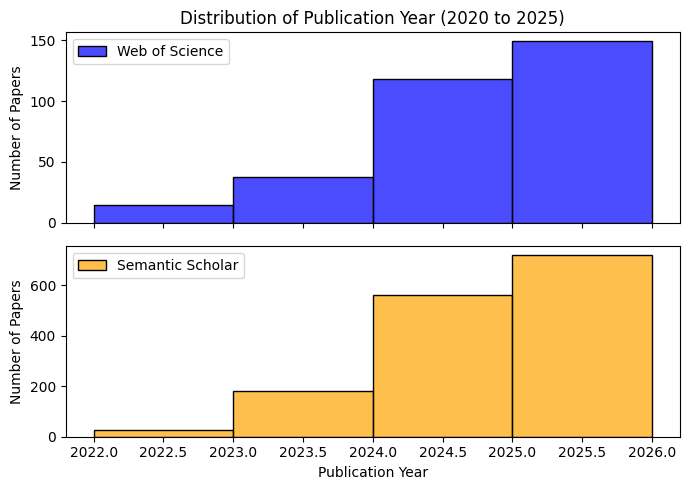

In [81]:
# Plot Distribution of Publication Years
fig, axes = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

sns.histplot(df_WoS_final['year'], color='blue', ax=axes[0], 
             kde=False, stat='count', bins=range(2022, 2027), alpha=0.7)
axes[0].set_title('Distribution of Publication Year (2020 to 2025)')
axes[0].set_ylabel('Number of Papers')
axes[0].legend(['Web of Science'])

sns.histplot(df_SS_final['year'], color='orange', ax=axes[1], 
             kde=False, stat='count', bins=range(2022, 2027), alpha=0.7)
axes[1].set_title('')
axes[1].set_xlabel('Publication Year')
axes[1].set_ylabel('Number of Papers')
axes[1].legend(['Semantic Scholar'])

plt.tight_layout()
plt.show()

## Screening

In [188]:
print(f'Number of rows in df_WoS_final_FULL: {len(df_WoS_final_FULL)}')
print(f'Number of rows in df_SS_final_FULL: {len(df_SS_final_FULL)}\n')

df_combined = pd.concat([df_WoS_final_FULL, df_SS_final_FULL], ignore_index=True)
print(f'Number of rows in combined dataframe before dropping duplicates: {len(df_combined)}')

df_combined = df_combined.drop_duplicates(subset = ['doi']).reset_index(drop = True)
print(f'Number of rows in combined dataframe after dropping DOI duplicates: {len(df_combined)}')

df_combined = df_combined.drop_duplicates(subset=['norm_title']).reset_index(drop=True)
df_combined = df_combined.drop(columns=['norm_title'])
print(f'Number of rows in combined dataframe after dropping duplicates: {len(df_combined)}')

print(f'Number of titles dropped due to duplicate titles: {len(df_combined) - len(df_WoS_final_FULL) - len(df_SS_final_FULL)}')

calc_recall_with_missing(df_combined)

Number of rows in df_WoS_final_FULL: 517
Number of rows in df_SS_final_FULL: 7194

Number of rows in combined dataframe before dropping duplicates: 7711
Number of rows in combined dataframe after dropping DOI duplicates: 5521
Number of rows in combined dataframe after dropping duplicates: 5478
Number of titles dropped due to duplicate titles: -2233


,Number of Papers Retrieved,Recall (All),Recall (Journal & Conf. Papers),Recall (Preprints),Missing Journal & Conf. Papers,Missing Preprints
0,5478,76.00%,92.86%,54.55%,The Potential and Challenges of Evaluating Att...,Addressing Systematic Non-response Bias with S...


In [245]:
# print out df_combined['researchAreas'].dropna().unique() and sort
unique_research_areas = set()
for areas in df_combined['researchAreas'].dropna().unique():
    for area in areas.split(','):
        unique_research_areas.add(area.strip())
unique_research_areas

{'Acoustics; Computer Science; Engineering; Imaging Science & Photographic Technology',
 'Acoustics; Engineering',
 'Acoustics; Engineering; Mechanics',
 'Agricultural and Food Sciences',
 'Agricultural and Food Sciences; Biology',
 'Agricultural and Food Sciences; Biology; Economics',
 'Agricultural and Food Sciences; Biology; Economics; Environmental Science',
 'Agricultural and Food Sciences; Biology; Environmental Science',
 'Agricultural and Food Sciences; Biology; Environmental Science; Medicine',
 'Agricultural and Food Sciences; Biology; Medicine',
 'Agricultural and Food Sciences; Biology; Physics',
 'Agricultural and Food Sciences; Business',
 'Agricultural and Food Sciences; Business; Economics',
 'Agricultural and Food Sciences; Business; Economics; Education; Environmental Science',
 'Agricultural and Food Sciences; Business; Economics; Environmental Science',
 'Agricultural and Food Sciences; Business; Economics; Environmental Science; Sociology',
 'Agricultural and Food 

In [214]:
# unique values in publicationTypes column of df_combined
unique_publication_types = set()
for types in df_combined['publicationTypes'].dropna().unique():
    for ptype in types.split(';'):
        unique_publication_types.add(ptype.strip())
unique_publication_types

{'Article',
 'Book',
 'Book Chapter',
 'Book, Conference',
 'Book, JournalArticle',
 'Book, JournalArticle, Conference',
 'Book, JournalArticle, Conference, Review',
 'Book, JournalArticle, Review',
 'Book, Review',
 'CaseReport, JournalArticle, Review',
 'Conference',
 'Conference, Review',
 'Dataset, JournalArticle',
 'Early Access',
 'Editorial',
 'Editorial Material',
 'Editorial, JournalArticle',
 'Editorial, JournalArticle, Review',
 'Editorial, LettersAndComments',
 'Editorial, LettersAndComments, Review',
 'Editorial, Review',
 'JournalArticle',
 'JournalArticle, Book',
 'JournalArticle, Book, Conference',
 'JournalArticle, Book, Conference, Review',
 'JournalArticle, Book, Review',
 'JournalArticle, CaseReport',
 'JournalArticle, CaseReport, Review',
 'JournalArticle, ClinicalTrial',
 'JournalArticle, ClinicalTrial, Review',
 'JournalArticle, Conference',
 'JournalArticle, Conference, Review',
 'JournalArticle, Editorial',
 'JournalArticle, Editorial, Review',
 'JournalArticle

In [219]:
INCLUDE_FIELDS = (
    'Arts & Humanities - Other Topics|'
    'Social Sciences - Other Topics|'
    'Business & Economics|'
    'Computer Science|'
    'Information Science & Library Science|'
    'Linguistics|'
    'Political Science|'
    'Environmental Sciences & Ecology|'
    'Mathematical Methods In Social Sciences|Government & Law'
)

EXCLUDE_FIELDS = ('Acoustics|Agricultur|Allergy|Anatomy & Morphology|Astronomy & Astrophysics|Atmospheric Sciences|Audiology & Speech-Language Pathology|Automation|Biodiversity & Conservation|Biology|Biotechnology & Applied Microbiology|Chemistry|Construction & Building Technology|Dermatology|Education|Energy & Fuels|Family Studies|Food Science & Technology|Gastroenterology & Hepatology|Geochemistry & Geophysics|Geography|Geology|Health|History|Imaging Science & Photographic Technology|Life Sciences & Biomedicine - Other Topics|Literature|Management Science|Materials Science|Mechanics|Medical|Medicine|Music|Neurosciences|Nursing|Oncology|Orthopedics|Otorhinolaryngology|Plant Sciences|Pediatrics|Pharmacology|Philosophy|Physics|Polymer Science|Psychiatry|Public Administration|Remote Sensing|Rheumatology|Robotics|Services|Social Work|Surgery|Thermodynamics|Transportation|Urology & Nephrology')

EXCLUDE_PUBTYPES = 'CaseReport|Dataset|Editorial|LettersAndComments|MetaAnalysis|News|Study'


def final_screen(df):
    # Step 1: Year filter
    step1 = df[df['year'].astype(str).str.isdigit() & (df['year'].astype(int) >= 2022)]
    print(f"Rows after year filter: {len(step1)}")
    
    # Step 2: Include fields
    step2 = step1[step1['researchAreas'].str.contains(INCLUDE_FIELDS, na=False)]
    print(f"Rows after INCLUDE_FIELDS filter: {len(step2)}")
    
    # Step 3: Exclude fields
    step3 = step2[~step2['researchAreas'].str.contains(EXCLUDE_FIELDS, na=False)]
    print(f"Rows after EXCLUDE_FIELDS filter: {len(step3)}")
    
    # Step 4: Exclude publication types
    step4 = step3[~step3['publicationTypes'].str.contains(EXCLUDE_PUBTYPES, na=False)]
    print(f"Rows after EXCLUDE_PUBTYPES filter: {len(step4)}")
    
    return step4

df_combined_filtered = final_screen(df_combined)

# print number of rows before final screening
print(f'Number of rows in combined dataframe before final screening: {len(df_combined)}')
print(f'Number of rows in combined dataframe after final screening: {len(df_combined_filtered)}')

calc_recall_with_missing(df_combined_filtered)

Rows after year filter: 3662
Rows after INCLUDE_FIELDS filter: 2876
Rows after EXCLUDE_FIELDS filter: 1687
Rows after EXCLUDE_PUBTYPES filter: 1683
Number of rows in combined dataframe before final screening: 5478
Number of rows in combined dataframe after final screening: 1683


,Number of Papers Retrieved,Recall (All),Recall (Journal & Conf. Papers),Recall (Preprints),Missing Journal & Conf. Papers,Missing Preprints
0,1683,72.00%,92.86%,45.45%,The Potential and Challenges of Evaluating Att...,Addressing Systematic Non-response Bias with S...


In [192]:
# save df_combined_filtered to CSV
df_combined_filtered.to_csv("df_final_combined_filtered.csv", index=False)

## Export RIS

In [189]:
# -------- RIS export helpers (Semantic Scholar + DOI fallback) --------

def _ss_enrich_biblio_with_batch(df: pd.DataFrame, sch: SemanticScholar) -> pd.DataFrame:
    """Add 'venue', 'publicationVenueName', 'venueType', 'authorsList', 'oaPdfUrl' columns via /paper/batch."""
    ids = [i for i in df.get("paperId", pd.Series()).dropna().astype(str).unique().tolist() if i]
    if not ids:
        for col in ["venue", "publicationVenueName", "venueType", "authorsList", "oaPdfUrl"]:
            df[col] = None
        return df

    rows = []
    chunksize = 100
    for i in range(0, len(ids), chunksize):
        batch = ids[i:i+chunksize]
        papers = sch.get_papers(batch, fields=[
            "paperId", "venue", "publicationVenue", "publicationTypes",
            "authors", "externalIds", "openAccessPdf", "url"
        ])
        for p in papers or []:
            pid = getattr(p, "paperId", None)
            # venue / container
            venue_str = getattr(p, "venue", None)
            pv = getattr(p, "publicationVenue", None)
            if isinstance(pv, dict):
                pv_name = pv.get("name")
                pv_type = pv.get("type")
            else:
                pv_name = getattr(pv, "name", None)
                pv_type = getattr(pv, "type", None)
            # authors list of strings
            a = getattr(p, "authors", None) or []
            a_names = []
            for it in a:
                if isinstance(it, dict):
                    nm = it.get("name")
                else:
                    nm = getattr(it, "name", None)
                if nm:
                    a_names.append(nm)
            # OA PDF
            o = getattr(p, "openAccessPdf", None)
            if isinstance(o, dict):
                oa_pdf = o.get("url")
            else:
                oa_pdf = getattr(o, "url", None)
            rows.append({
                "paperId": pid,
                "venue": venue_str,
                "publicationVenueName": pv_name,
                "venueType": pv_type,
                "authorsList": a_names if a_names else None,
                "oaPdfUrl": oa_pdf,
            })
    add_df = pd.DataFrame(rows).drop_duplicates(subset=["paperId"]) if rows else \
             pd.DataFrame(columns=["paperId","venue","publicationVenueName","venueType","authorsList","oaPdfUrl"])
    return df.merge(add_df, on="paperId", how="left")


def _ris_type_from_pubtypes(pubtypes):
    """Map Semantic Scholar publicationTypes to RIS TY codes."""
    s = set([t.lower() for t in (pubtypes or [])]) if isinstance(pubtypes, list) else {str(pubtypes).lower()} if pubtypes else set()
    if any(x in s for x in ["journalarticle", "journal-article", "journal"]): return "JOUR"
    if any(x in s for x in ["conference", "proceedings-article", "conferencepaper", "conference paper"]): return "CONF"
    if any(x in s for x in ["book"]): return "BOOK"
    if any(x in s for x in ["bookchapter", "book-chapter", "chapter"]): return "CHAP"
    if any(x in s for x in ["thesis", "phdthesis", "mastersthesis"]): return "THES"
    if any(x in s for x in ["preprint", "workingpaper", "report"]): return "RPRT"
    return "GEN"


def _ris_name(last_first: str) -> str:
    """Ensure 'Last, First' format; best-effort for simple 'First Last' names."""
    if not last_first:
        return ""
    name = last_first.strip()
    if "," in name:
        return name  # already 'Last, First'
    parts = name.split()
    if len(parts) == 1:
        return parts[0]
    return f"{parts[-1]}, {' '.join(parts[:-1])}"


def _row_to_ris(rec: dict) -> str:
    """Build a single RIS record from a dict-like row."""
    ty = _ris_type_from_pubtypes(rec.get("publicationTypes"))
    title = rec.get("title") or ""
    year = rec.get("year")
    doi = rec.get("doi") or ""
    url = rec.get("url") or rec.get("oaPdfUrl") or ""
    # container (journal/conference name)
    container = rec.get("publicationVenueName") or rec.get("venue") or ""
    # authors: prefer list from enrichment; else split the string column
    authors_list = rec.get("authorsList")
    if not authors_list:
        s = rec.get("authors") or ""
        authors_list = [a.strip() for a in s.split(",") if a.strip()] if s else []
    fields = []
    fields.append(f"TY  - {ty}")
    if title:
        fields.append(f"TI  - {title}")
    if container:
        # JO for journals; T2 is also accepted broadly. Use JO as generic container.
        fields.append(f"JO  - {container}")
    for a in authors_list:
        nm = _ris_name(a)
        if nm:
            fields.append(f"AU  - {nm}")
    if year:
        fields.append(f"PY  - {int(year)}")
    if doi:
        fields.append(f"DO  - {doi}")
    if url:
        fields.append(f"UR  - {url}")
    # keywords from fieldsOfStudy
    fos = rec.get("fieldsOfStudy")
    if isinstance(fos, str):
        kws = [k.strip() for k in fos.split(";") if k.strip()]
        for k in kws:
            fields.append(f"KW  - {k}")
    # abstract (optional; can be long)
    abstract = rec.get("abstract")
    if abstract:
        fields.append(f"AB  - {abstract}")
    # identifier
    pid = rec.get("paperId")
    if pid:
        fields.append(f"ID  - S2:{pid}")
    fields.append("ER  - ")
    return "\n".join(fields)


def _doi_provider_ris(doi: str, timeout=15) -> str | None:
    """Try DOI content negotiation to fetch RIS from the publisher/Crossref."""
    if not doi:
        return None
    try:
        resp = requests.get(
            f"https://doi.org/{doi}",
            headers={"Accept": "application/x-research-info-systems"},
            timeout=timeout,
            allow_redirects=True,
        )
        if resp.status_code == 200 and resp.text.strip():
            return resp.text
    except Exception:
        pass
    return None


def export_df_to_ris(df: pd.DataFrame, out_path: str,
                     use_doi_provider: bool = True,
                     provider_backoff_sec: float = 0.2,
                     enrich_biblio: bool = True) -> None:
    """
    Export a DataFrame of papers to a .ris file.
    If use_doi_provider=True and DOI exists, try to fetch publisher RIS first; fallback to local RIS.
    If enrich_biblio=True, add venue/container and clean authors via S2 /paper/batch before export.
    """
    dfx = df.copy()

    sch = None
    if enrich_biblio:
        sch = SemanticScholar(api_key=api_key_SS, timeout=45, retry=True)
        dfx = _ss_enrich_biblio_with_batch(dfx, sch)

    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    records = []
    for _, row in dfx.iterrows():
        ris_txt = None
        if use_doi_provider:
            ris_txt = _doi_provider_ris(str(row.get("doi", "")).strip())
            if provider_backoff_sec and ris_txt is not None:
                time.sleep(provider_backoff_sec)
        if not ris_txt:
            ris_txt = _row_to_ris(row)
        records.append(ris_txt.rstrip())  # ensure clean boundary

    with open(out_path, "w", encoding="utf-8") as f:
        f.write("\n\n".join(records) + "\n")

    print(f"Wrote {len(records)} RIS records to: {out_path}")

In [ ]:
# Example: ensure df_SS_llm_survey_simB exists, then export
out_file = os.path.join("asreview", "finalscreened.ris")

export_df_to_ris(df_combined_filtered, out_file,
                 use_doi_provider=False,   
                 enrich_biblio=True)        # add venue/authorsList columns before export

# Compare AI vs. Database Search

In [220]:
# Filter out df_Elicit, where doi contains arXiv or biorxiv
df_Elicit_filtered = df_Elicit[~df_Elicit['DOI'].str.contains('arxiv|biorxiv', case=False, na=False)].reset_index(drop=True)
df_Elicit_filtered_archive = df_Elicit[df_Elicit['DOI'].str.contains('arxiv|biorxiv', case=False, na=False)].reset_index(drop=True)

In [215]:
df_Elicit_filtered_archive

,title,Authors,DOI,DOI link,Venue,Citation count,Year,Abstract summary,Methodology,"Supporting quotes for ""Methodology""","Supporting tables for ""Methodology""","Reasoning for ""Methodology"""
0,Specializing Large Language Models to Simulate...,"Yong Cao, Haijiang Liu, Arnav Arora, Isabelle ...",10.48550/arXiv.2502.07068,https://doi.org/10.48550/arXiv.2502.07068,North American Chapter of the Association for ...,6,2025,Large language models can be specialized to si...,- Specializing LLMs for survey simulation usin...,"- ""In this study, our goal is instead to spe...","- ""(Page 3, Table 1) | **Instruction** | How...",- The study aims to specialize large language ...
1,Random Silicon Sampling: Simulating Human Sub-...,"Seungjong Sun, Eungu Lee, Dongyan Nan, Xiangyi...",10.48550/arXiv.2402.18144,https://doi.org/10.48550/arXiv.2402.18144,arXiv.org,24,2024,Large language models can simulate human surve...,"- Created a ""random silicon sample"" of synthet...","- ""Our study analyzed 1) a language model th...",NaN,"- The study uses a method called ""random silic..."
2,Uncertainty Quantification for LLM-Based Surve...,"Chengpiao Huang, Yuhang Wu, Kaizheng Wang",10.48550/arXiv.2502.17773,https://doi.org/10.48550/arXiv.2502.17773,arXiv.org,1,2025,The paper presents a method to use large langu...,- Use LLMs to simulate human responses to surv...,"- ""Ideally, we would like to pick k such tha...",NaN,- The methodology involves using large languag...
3,Large Language Models as Subpopulation Represe...,"Gabriel Simmons, Christopher Hare",10.48550/arXiv.2310.17888,https://doi.org/10.48550/arXiv.2310.17888,arXiv.org,20,2023,Large language models can be used to simulate ...,The methodology involves using Large Language ...,"- ""This review draws together a body of lite...","- ""(Page 10, Table 1) | Method ...",- The paper is a review of existing literature...
4,Language Model Fine-Tuning on Scaled Survey Da...,"Joseph Suh, Erfan Jahanparast, Suhong Moon, Mi...",10.48550/arXiv.2502.16761,https://doi.org/10.48550/arXiv.2502.16761,Annual Meeting of the Association for Computat...,6,2025,Fine-tuning large language models on scaled su...,- Fine-tuning large language models (LLMs) on ...,"- ""Here, we propose directly finetuning LLMs...",NaN,- The study involves fine-tuning large languag...
...,...,...,...,...,...,...,...,...,...,...,...,...
186,Exposing Bias in Online Communities through La...,"Celine Wald, Lukas Pfahler",10.48550/arXiv.2306.02294,https://doi.org/10.48550/arXiv.2306.02294,arXiv.org,6,2023,Large language models trained on online commun...,NaN,NaN,NaN,NaN
187,Style Over Substance: Evaluation Biases for La...,"Minghao Wu, Alham Fikri Aji",10.48550/arXiv.2307.03025,https://doi.org/10.48550/arXiv.2307.03025,International Conference on Computational Ling...,52,2023,Crowd-sourced and expert evaluations of large ...,NaN,NaN,NaN,NaN
188,Tackling Bias in Pre-trained Language Models: ...,"Vithya Yogarajan, Gillian Dobbie, Te Taka Keeg...",10.48550/arXiv.2312.01509,https://doi.org/10.48550/arXiv.2312.01509,arXiv.org,14,2023,The paper discusses the need to address biases...,NaN,NaN,NaN,NaN
189,Challenging the appearance of machine intellig...,"Alaina N. Talboy, Elizabeth Fuller",10.48550/arXiv.2304.01358,https://doi.org/10.48550/arXiv.2304.01358,arXiv.org,27,2023,Large language models exhibit cognitive biases...,NaN,NaN,NaN,NaN


In [218]:
# Find the percentage of df_Elicit DOI that are present in df_combined_filtered doi
elicit_doi_set = set(df_Elicit_filtered['DOI'].dropna().apply(normalize_doi).tolist())
combined_doi_set = set(df_combined_filtered['doi'].dropna().apply(normalize_doi).tolist())
common_dois = elicit_doi_set.intersection(combined_doi_set)
percentage_doi_in_combined = (len(common_dois) / len(elicit_doi_set)) * 100 if elicit_doi_set else 0.0
print(f"Percentage of Elicit DOIs present in the final combined filtered dataset: {percentage_doi_in_combined:.2f}%")


Percentage of Elicit DOIs present in the final combined filtered dataset: 22.43%
